In [2]:
from google.colab import drive
drive.mount('/gdrive')

Mounted at /gdrive


In [3]:
cd "/gdrive/My Drive/Tesis/master_thesis"

/gdrive/My Drive/Tesis/master_thesis


In [4]:
pip install nilearn & pip install elasticdeform & pip install ml_collections

     |████████████████████████████████| 88 kB 3.0 MB/s 
     |▍                               | 51 kB 7.8 MB/s eta 0:00:01Collecting elasticdeform
     |███████████▍                    | 1.7 MB 8.4 MB/s eta 0:00:01  Downloading elasticdeform-0.4.9-cp37-cp37m-manylinux2010_x86_64.whl (93 kB)
     |████████████████████████████████| 93 kB 2.0 MB/s 
     |███████████████▉                | 2.4 MB 8.4 MB/s eta 0:00:01Requirement already satisfied: numpy in /usr/local/lib/python3.7/dist-packages (from elasticdeform) (1.19.5)
     |████████████████████████████████| 4.9 MB 8.4 MB/s 


In [5]:
pip install tensorflow-addons

     |████████████████████████████████| 679 kB 7.6 MB/s 


In [6]:
pip install ml_collections

In [7]:
from utils import utils
from train import create_train_dataset, create_validation_dataset, show_dataset

DATASET_PATH = './dataset_test/' 
roots = [
    'HLN-12',
    'Colin27',
    'MMRR-3T7T-2',
    'NKI-RS-22',
    'NKI-TRT-20',
    'MMRR-21',
    'OASIS-TRT-20',
    'Twins-2',
    'Afterthought'
]
PREFIX_PATH = './data/'
LUT_PATH = './data/FreeSurferColorLUT.txt'
roots = [PREFIX_PATH + root for root in roots]
lut_file = utils.load_lut(LUT_PATH)
config = {
    'RAS': True, 
    'normalize': False
}
# print(lut_file)

/usr/local/lib/python3.7/dist-packages/nilearn/datasets/__init__.py:89: FutureWarning: Fetchers from the nilearn.datasets module will be updated in version 0.9 to return python strings instead of bytes and Pandas dataframes instead of Numpy arrays.
  "Numpy arrays.", FutureWarning)


In [8]:
import tensorflow as tf
from tensorflow.keras import layers

class ConvolutionalBlock(layers.Layer):

    def __init__(self, filters, kernel_size, padding, dropout_rate, activation, **kwargs):
        super(ConvolutionalBlock, self).__init__(**kwargs)
        self.filters = filters
        self.kernel_size = kernel_size
        self.padding = padding
        self.dropout_rate = dropout_rate
        self.activation = activation

    def build(self, input_shape):
        self.w = tf.random_normal_initializer(mean=0.0, stddev=1e-4)

        if (self.bias):
            self.b = tf.constant_initializer(0.0)
        else:
            self.b = None

        self.conv_a = layers.Conv2D(
            filters=self.filters, 
            kernel_size=self.kernel_size, 
            strides=1, 
            padding='same',
            kernel_initializer=self.w,
            use_bias=True,
            bias_initializer=self.b
        )

        self.max_pool_a = layers.MaxPool2D(pool_size=(2,2))
        self.bn_a = layers.BatchNormalization()
        self.activation_fnc = layers.Activation('relu')

    def call(self, inputs):
        x = self.conv_a(inputs)
        x = self.max_pool_a(x)
        x = self.bn_a(x)
        return self.activation_fnc(x)

    def get_config(self):
      config = super().get_config().copy()
      config.update({
          'filters' : self.filters,
          'kernel_size' : self.kernel_size,
          'padding' : self.padding,
          'dropout_rate' : self.dropout_rate,
          'activation' : self.activation,
      })
      return config

class MLPBlock(layers.Layer):
    def __init__(self, hidden_units, dropout_rate, activation=None, **kwarks):
        super(MLPBlock, self).__init__(**kwarks)
        self.hidden_units = hidden_units
        self.dropout_rate = dropout_rate

        if not activation:
            activation = tf.nn.gelu

        self.activation = activation

        # creating layers
        self.layers = []

        for units in self.hidden_units:
            self.layers.append(layers.Dense(units, activation=self.activation))
            self.layers.append(layers.Dropout(self.dropout_rate))

    def call(self, inputs):

        for layer in self.layers:
            inputs = layer(inputs)

        return inputs

    def get_config(self):
      config = super().get_config().copy()
      config.update({
          'hidden_units' : self.hidden_units,
          'dropout_rate' : self.dropout_rate,
          'activation' : self.activation,
          'layers' : self.layers,
      })
      return config
      
def mlp(x, hidden_units, dropout_rate):
    for units in hidden_units:
        x = layers.Dense(units, activation=tf.nn.gelu)(x)
        x = layers.Dropout(dropout_rate)(x)
    return x

class Patches(layers.Layer):
    def __init__(self, patch_size, **kwarks):
        super(Patches, self).__init__(**kwarks)
        self.patch_size = patch_size

    def call(self, images):
        batch_size = tf.shape(images)[0]
        patches = tf.image.extract_patches(
            images=images,
            sizes=[1, self.patch_size, self.patch_size, 1],
            strides=[1, self.patch_size, self.patch_size, 1],
            rates=[1, 1, 1, 1],
            padding="VALID",
        )
        patch_dims = patches.shape[-1]
        patches = tf.reshape(patches, [batch_size, -1, patch_dims])
        return patches

    def get_config(self):
      config = super().get_config().copy()
      config.update({
          'patch_size' : self.patch_size
      })
      return config

class PatchEncoder(layers.Layer):
    def __init__(self, num_patches, projection_dim, **kwarks):
        super(PatchEncoder, self).__init__(**kwarks)
        self.num_patches = num_patches
        
        # Layers
        self.projection = layers.Dense(units=projection_dim)
        self.position_embedding = layers.Embedding(
            input_dim=num_patches, output_dim=projection_dim
        )

    def call(self, patch):
        positions = tf.range(start=0, limit=self.num_patches, delta=1)
        encoded = self.projection(patch) + self.position_embedding(positions)
        return encoded

    def get_config(self):
      config = super().get_config().copy()
      config.update({
          'num_patches' : self.num_patches,
          # layers
          'projection' : self.projection,
          'position_embedding' : self.position_embedding,
      })
      return config

class TransformerBlock(layers.Layer):
    def __init__(self, num_heads, projection_dim, dropout_rate, normalization_rate, transformer_units, **kwarks):
        super(TransformerBlock, self).__init__(**kwarks)
        self.num_heads = num_heads
        self.projection_dim = projection_dim
        self.dropout_rate = dropout_rate
        self.normalization_rate = normalization_rate
        self.transformer_units = transformer_units

        # Layers
        self.ln_a = layers.LayerNormalization(epsilon=self.normalization_rate)
        self.attention_layer_a = layers.MultiHeadAttention(
            num_heads = self.num_heads,
            key_dim = self.projection_dim,
            dropout = self.dropout_rate,
        )
        self.add_a = layers.Add()

        self.ln_b = layers.LayerNormalization(epsilon=self.normalization_rate)
        self.mlp_block_b = MLPBlock(
            hidden_units=self.transformer_units, 
            dropout_rate=self.dropout_rate
        )

        self.add_b = layers.Add()

    def call(self, encoded_patches):
        x1 = self.ln_a(encoded_patches)
        attention_layer = self.attention_layer_a(x1, x1)
        # attention_layer = self.softmax_b(attention_layer)
        
        x2 = self.add_a([attention_layer, encoded_patches])
        x3 = self.ln_b(x2)
        x3 = self.mlp_block_b(x3)
        x3 = self.add_b([x3, x2])
        return x3

    def get_config(self):
      config = super().get_config().copy()
      config.update({
          'num_heads' : self.num_heads,
          'projection_dim' : self.projection_dim,
          'dropout_rate' : self.dropout_rate,
          'normalization_rate' : self.normalization_rate,
          'transformer_units' : self.transformer_units,
          # layers
          'ln_a' : self.ln_a,
          'attention_layer_a' : self.attention_layer_a,
          'add_a' : self.add_a,
          'ln_b' : self.ln_b,
          'mlp_block_b' : self.mlp_block_b,
          'add_b' : self.add_b,
      })
      return config

class DecoderBlockCup(layers.Layer):

    def __init__(self, target_shape, filters, normalization_rate, pool_size=(2, 1), kernel_size=3, activation=None, **kwarks):
        super(DecoderBlockCup, self).__init__(**kwarks)
        self.normalization_rate = normalization_rate
        self.target_shape = target_shape
        self.filters = filters
        self.kernel_size = kernel_size
        self.pool_size = pool_size

        if not activation:
            activation = tf.nn.relu

        self.activation = activation

        # Layers
        self.ln_a = layers.LayerNormalization(epsilon=self.normalization_rate, name="decoder_block_cup_ln_a")
        self.reshape_a = layers.Reshape(target_shape=self.target_shape, name="decoder_block_cup_reshape_1")
        # self.conv_a = layers.Conv2D(filters=self.filters, kernel_size=self.kernel_size*2, strides=1, padding='same')
        # self.max_pool_a = layers.MaxPooling2D(pool_size=self.pool_size)
        # self.bn_a = layers.BatchNormalization()
        # self.activation_fnc = layers.Activation('relu')
        # self.upsample_a = layers.UpSampling2D(
        #     size=(2,2), interpolation='bilinear'
        # )

    def call(self, encoder_output):
        x = self.ln_a(encoder_output)
        x = self.reshape_a(x)
        
        # x = self.conv_a(x)
        # x = self.max_pool_a(x)
        # x = self.bn_a(x)
        # return self.activation_fnc(x)
        # x = self.conv_a(x)    
        # x = self.max_pool_a(x)
        # x = self.bn_a(x)
        # x = self.activation_fnc(x)
        # x = self.upsample_a(x)
        return x

    def get_config(self):
      config = super().get_config().copy()
      config.update({
          'normalization_rate' : self.normalization_rate,
          'target_shape' : self.target_shape,
          'filters' : self.filters,
          'kernel_size' : self.kernel_size,
          'pool_size' : self.pool_size,
          # layers
          'ln_a' : self.ln_a,
          'reshape_a' : self.reshape_a,
      })
      return config

class DecoderUpsampleBlock(layers.Layer):
    
    def __init__(self, filters, kernel_size=3, strides=(1, 1), pool_size=(2, 1), **kwarks):
        super(DecoderUpsampleBlock, self).__init__(**kwarks)
        self.filters = filters
        self.kernel_size = kernel_size
        self.strides = strides
        self.pool_size = pool_size

        # Layers
        self.upsample_a = layers.UpSampling2D(
            size=(2,2), interpolation='bilinear'
        )

        self.conv_a = layers.Conv2D(
            filters=self.filters, 
            kernel_size=self.kernel_size, 
            strides=self.strides, 
            padding='same'
        )

        self.conv_transpose_a = layers.Conv2DTranspose(
            filters=self.filters, 
            kernel_size=self.kernel_size, 
            strides=self.strides, 
            padding='same',
        )
        
        # self.max_pool_a = layers.MaxPooling2D(pool_size=self.pool_size)
        self.bn_a = layers.BatchNormalization()
        self.activation_fnc = layers.Activation('relu')
        
    def call(self, decoder_input):
        # x = self.upsample_a(decoder_input)
        # x = self.upsample_a(x)

        x = self.conv_a(decoder_input)
        # x = self.conv_transpose_a(decoder_input)    
        x = self.bn_a(x)
        # x = self.conv_a(x)

        # x = self.max_pool_a(x)
        # x = self.bn_a(x)
        # x = self.activation_fnc(x)
        x = self.upsample_a(x)
        x = self.activation_fnc(x)
        return x

    def get_config(self):
      config = super().get_config().copy()
      config.update({
          'filters' : self.filters,
          'kernel_size' : self.kernel_size,
          'strides' : self.strides,
          'pool_size' : self.pool_size,
          # layers
          'conv_a' : self.conv_a,
          'bn_a' : self.bn_a,
          'upsample_a' : self.upsample_a,
          'activation_fnc' : self.activation_fnc,
      })
      return config

class DecoderSegmentationHead(layers.Layer):

    def __init__(self, filters=1, kernel_size=3, strides=1, target_shape=(256, 256, 16), **kwarks):
        super(DecoderSegmentationHead, self).__init__(**kwarks)
        self.filters = filters
        self.kernel_size = kernel_size
        self.strides = strides
        self.target_shape = target_shape

        # Layers
        self.reshape_a = layers.Reshape(target_shape=(self.target_shape))
        self.conv_a = layers.Conv2D(
            filters=self.filters,
            kernel_size=self.kernel_size,
            strides=self.strides,
            padding='same',
        )
    
    def call(self, decoder_upsample_block):
        x = self.reshape_a(decoder_upsample_block)
        return self.conv_a(x)

    def get_config(self):
      config = super().get_config().copy()
      config.update({
          'filters' : self.filters,
          'kernel_size' : self.kernel_size,
          'strides' : self.strides,
          'target_shape' : self.target_shape,
          # layers
          'conv_a' : self.conv_a,
          'reshape_a' : self.reshape_a,
      })
      return config

class DecoderDense(layers.Layer):
    def __init__(self, normalization_rate, **kwarks):
        super(DecoderDense, self).__init__(**kwarks)
        self.normalization_rate = normalization_rate

        # Layers
        self.ln_a = layers.LayerNormalization(epsilon=self.normalization_rate, name="decoder_block_cup_ln_a")
        self.flatten_a = layers.Flatten()
        self.dropout_a = layers.Dropout(0.5)
        self.reshape_a = layers.Reshape(target_shape=(256,256,1))

    def call(self, inputs):
        x = self.ln_a(inputs)
        x = self.flatten_a(x)
        x = self.dropout_a(x)
        return self.reshape_a(x)

In [9]:
from tensorflow.keras import Model, Input

def build_model(config):
    inputs = Input(shape=config.image_size)
    patches = Patches(config.transformer.patch_size, name="patches_0")(inputs)
    encoded_patches = PatchEncoder(
        num_patches=config.transformer.num_patches, 
        projection_dim=config.transformer.projection_dim,
        name='encoded_patches_0',    
    )(patches)

    # print(f"enconded patches size {encoded_patches.shape}")

    transformer_blocks = []
    for idx in range(config.transformer.layers):
        # print(f"Starting {idx} iteration")
        encoded_patches = TransformerBlock(
            num_heads=config.transformer.num_heads, 
            projection_dim=config.transformer.projection_dim, 
            dropout_rate=config.transformer.dropout_rate, 
            normalization_rate=config.transformer.normalization_rate, 
            transformer_units=config.transformer.units, 
            name="transformer_block_"+str(idx)
        )(encoded_patches)
        transformer_blocks.append(encoded_patches)
    
    filters = [3, 128, 64, 32, 1]
    residual_block = None
    for idx in range(len(filters)):
      if not idx:
        x = DecoderBlockCup(
            target_shape=(config.image_height//16, config.image_width//16, config.transformer.projection_dim),
            filters=filters[idx],
            normalization_rate=config.transformer.normalization_rate,
            name=f'decoder_cup_{idx}'
        )(encoded_patches)
      else:
          x = DecoderUpsampleBlock(filters=filters[idx], kernel_size=3)(x)

          if (config.residual_blocks):
            num = 0
            if (idx == 1):
              num = -2
            elif (idx == 2):
              num = int(len(transformer_blocks)/2)-1

            if idx == 1:
              residual_block = DecoderBlockCup(
                  target_shape=(config.image_height//16, config.image_width//16, config.transformer.projection_dim),
                  filters=filters[idx],
                  normalization_rate=config.transformer.normalization_rate,
                  name=f'decoder_cup_{idx}'
              )(transformer_blocks[num])
              residual_block = DecoderUpsampleBlock(filters=filters[idx], kernel_size=3)(residual_block)
              x = layers.Add()([x, residual_block])


            if (idx == 2):
              residual_block = DecoderBlockCup(
                  target_shape=(config.image_height//16, config.image_width//16, config.transformer.projection_dim),
                  filters=filters[idx-1],
                  normalization_rate=config.transformer.normalization_rate,
                  name=f'decoder_cup_{idx}'
              )(transformer_blocks[num])
              residual_block = DecoderUpsampleBlock(filters=filters[idx-1], kernel_size=3)(residual_block)
              residual_block = DecoderUpsampleBlock(filters=filters[idx], kernel_size=3)(residual_block)

              x = layers.Add()([x, residual_block])
            
            if (idx == 3):
              residual_block = DecoderBlockCup(
                  target_shape=(config.image_height//16, config.image_width//16, config.transformer.projection_dim),
                  filters=filters[idx-1],
                  normalization_rate=config.transformer.normalization_rate,
                  name=f'decoder_cup_{idx}'
              )(transformer_blocks[num])
              residual_block = DecoderUpsampleBlock(filters=filters[idx-2], kernel_size=3)(residual_block)
              residual_block = DecoderUpsampleBlock(filters=filters[idx-1], kernel_size=3)(residual_block)
              residual_block = DecoderUpsampleBlock(filters=filters[idx], kernel_size=3)(residual_block)
              x = layers.Add()([x, residual_block])

    # x = DecoderUpsampleBlock(filters=32, kernel_size=3)(x)
    # x = DecoderUpsampleBlock(filters=3, kernel_size=3)(x)

    return Model(inputs=inputs, outputs=x)

Config:  activation: softmax
batch_size: 32
data_augmentation: false
dataset_path: dataset_test/
image_channels: 1
image_height: 256
image_size: !!python/tuple [256, 256, 1]
image_width: 256
learning_rate: 0.001
momentum: 0.9
n_classes: 1
num_epochs: 10
residual_blocks: true
transformer:
  dropout_rate: 0.1
  layers: 8
  normalization_rate: 1.0e-06
  num_heads: 12
  num_patches: 256
  patch_size: 16
  projection_dim: 256
  units: [768, 256]
weight_decay: 0.0001



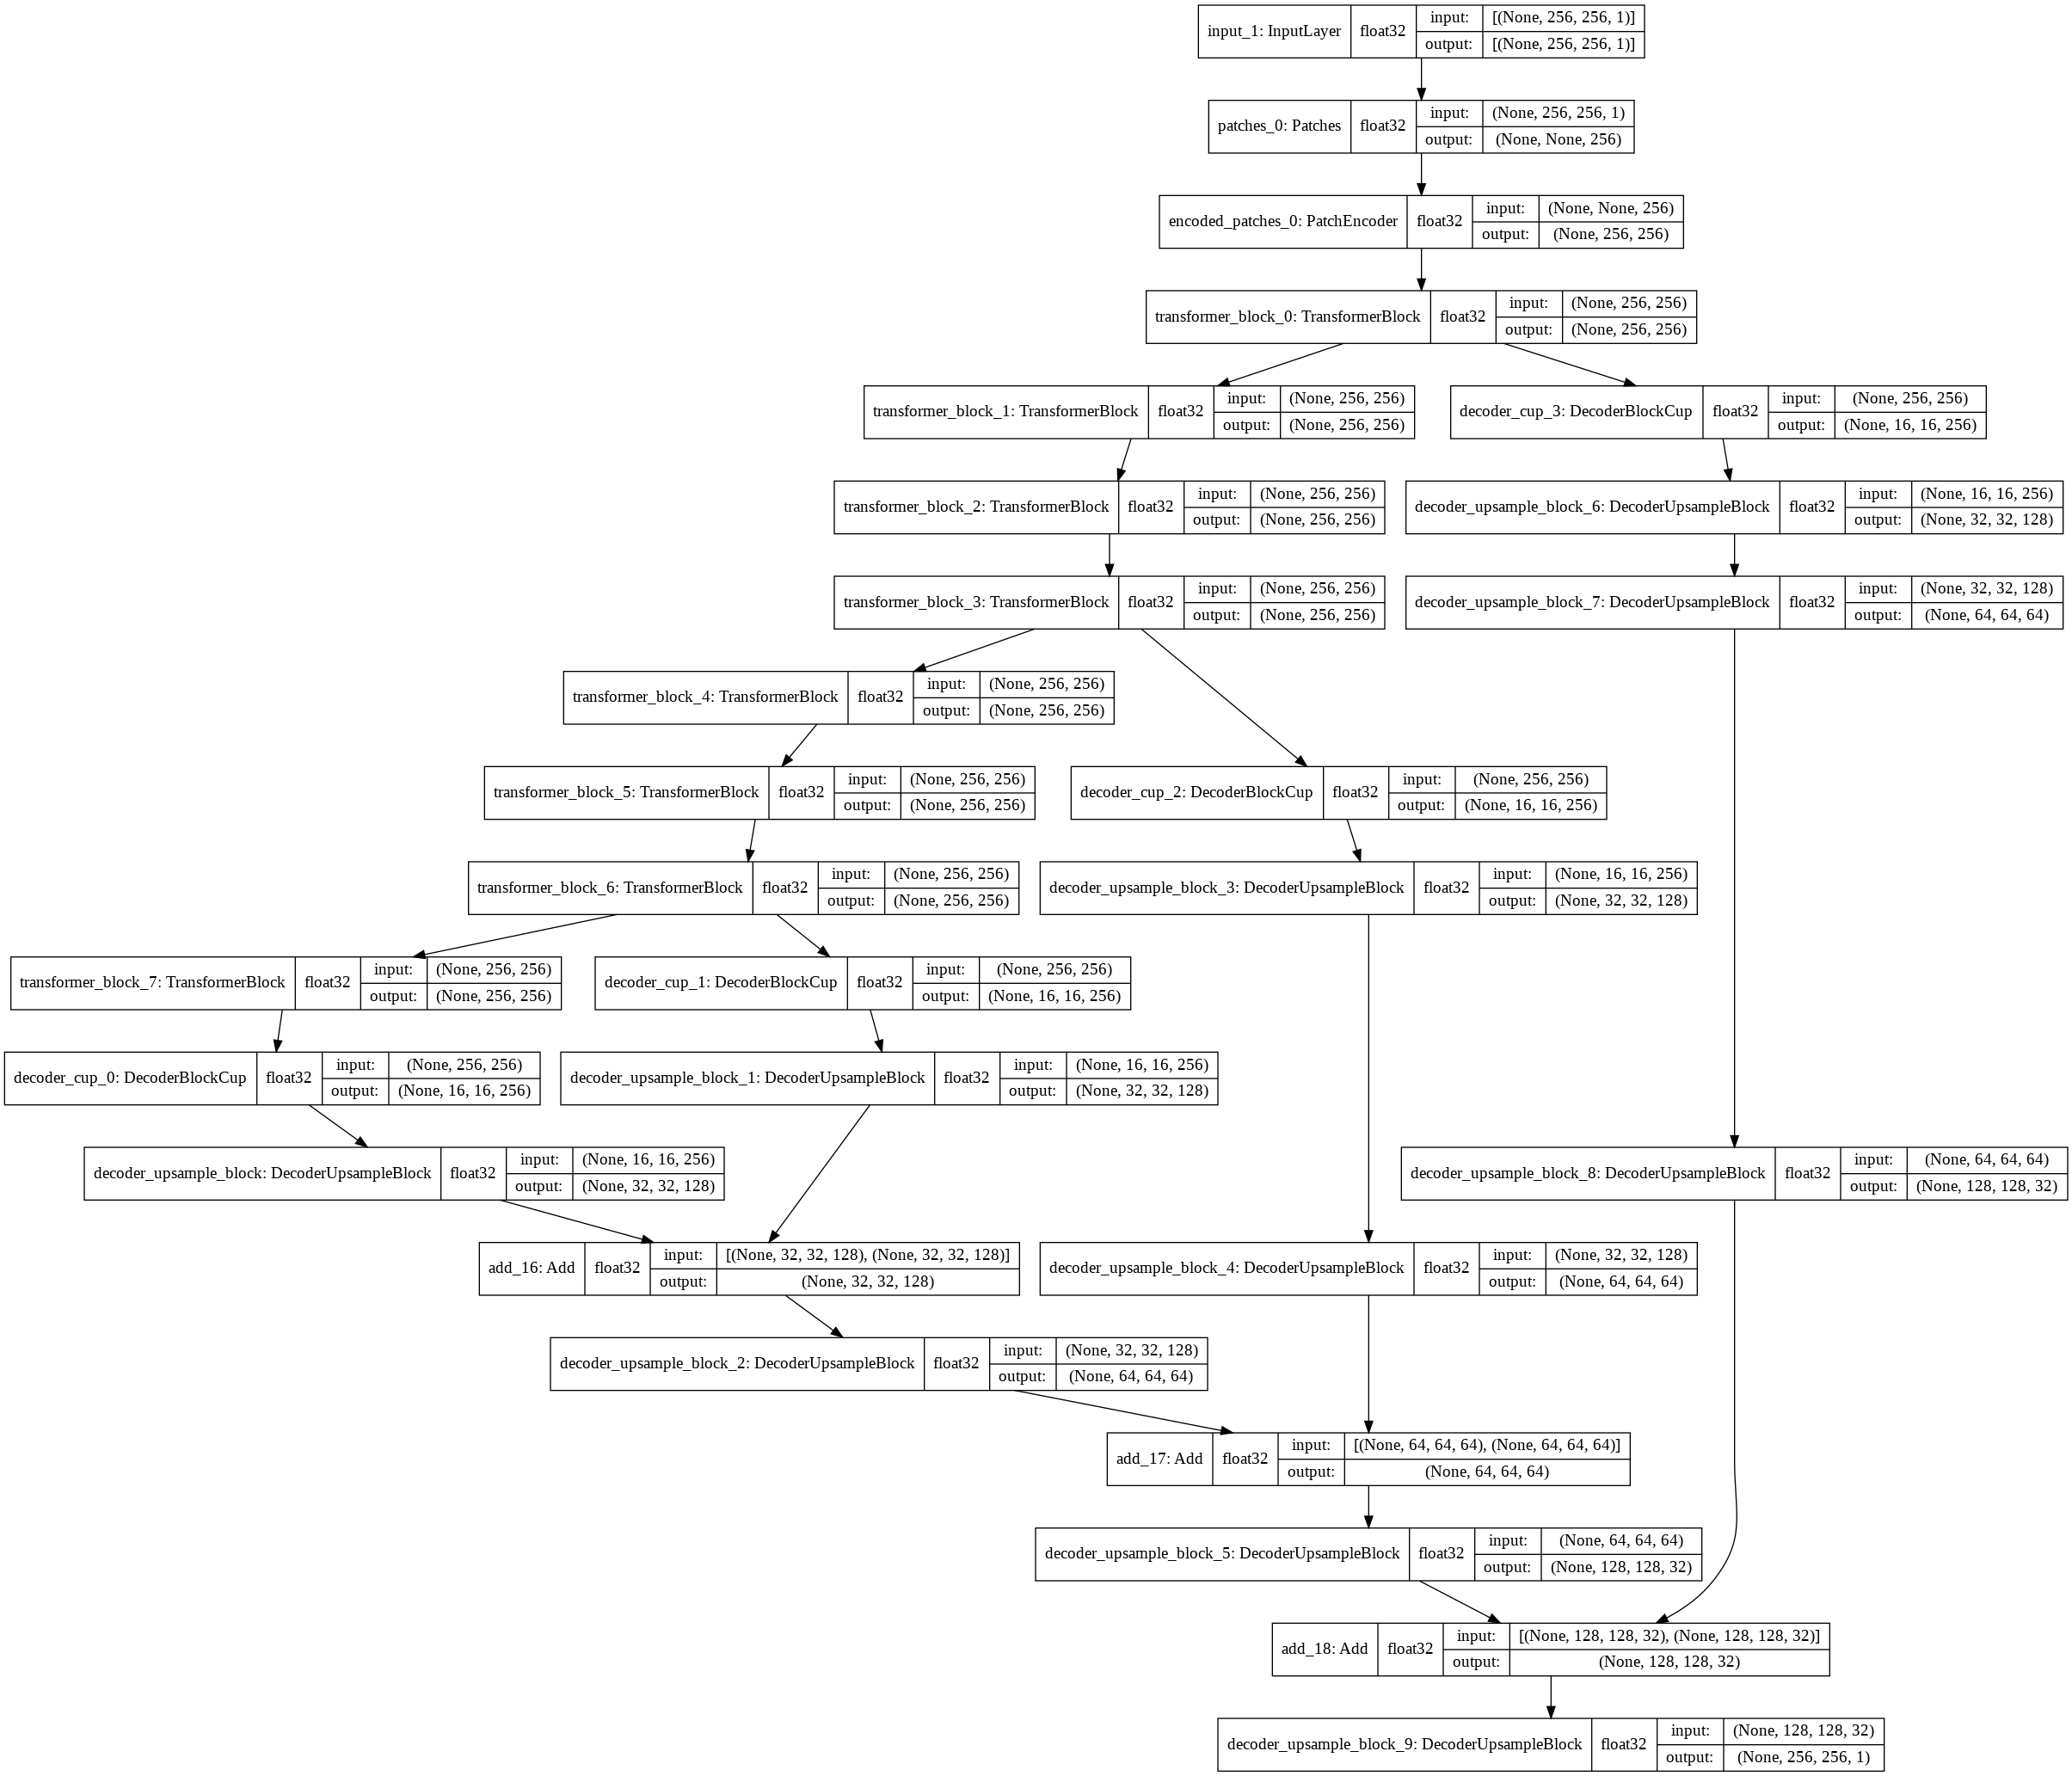

In [10]:
import ml_collections

def get_config_1():
    """
        Returns the transformer configuration 1
    """

    config = ml_collections.ConfigDict()
    config.dataset_path = 'dataset/'
    config.learning_rate = 0.001
    config.weight_decay = 1e-4
    config.momentum = 0.9
    config.batch_size = 16
    config.num_epochs = 10
    config.image_height = 256
    config.image_width = 256
    config.image_channels = 1
    config.image_size = (config.image_height, config.image_width, config.image_channels)
    config.residual_blocks = True
    config.data_augmentation = False
    
    config.transformer = ml_collections.ConfigDict()
    config.transformer.patch_size = 16
    config.transformer.num_patches = (config.image_size[0] // config.transformer.patch_size)**2
    config.transformer.projection_dim = 256
    config.transformer.units = [
        config.transformer.projection_dim * 3, # (3) 1536 --  (4) 2048
        config.transformer.projection_dim, # 512
        # config.transformer.projection_dim, # 64
    ]
    config.transformer.layers = 8
    config.transformer.num_heads = 12
    config.transformer.dropout_rate = 0.1
    config.transformer.normalization_rate = 1e-6

    config.n_classes = 1
    config.activation = 'softmax'

    return config

import tensorflow as tf

config_ml = get_config_1()
config_ml.batch_size = 32
config_ml.dataset_path = 'dataset_test/'
# config_ml.transformer.layers = 5
# config_ml.transformer.num_heads = 4

# config_ml.transformer.projection_dim = 512

# config_ml.transformer.units = [
#     config_ml.transformer.projection_dim * 2, # (3) 1536 --  (4) 2048
#     config_ml.transformer.projection_dim, # 512
#     # config.transformer.projection_dim, # 64
# ]

config_ml.data_augmentation = False
config_ml.residual_blocks = True
model = build_model(config_ml)

print("Config: ", config_ml)

VIEW_TRAINIG = 'axial/'
LABEL = 'left-cerebellum-white-matter'

config = {
    'DATASET_PATH': config_ml.dataset_path,
    'VIEW_TRAINIG': VIEW_TRAINIG,
    'LABEL': LABEL,
    'IMAGE_SIZE': (config_ml.image_height, config_ml.image_width),
    'BATCH_SIZE': config_ml.batch_size,
    'DATA_AUGMENTATION': config_ml.data_augmentation,
}

# train_gen = create_train_dataset(config=config)
# val_gen = create_validation_dataset(config=config)

tf.keras.utils.plot_model(
    model,
    to_file='model.png',
    show_shapes=True,
    show_dtype=True,
    show_layer_names=True,
    rankdir="TB",
    expand_nested=False,
    dpi=96,
)

In [11]:
model.summary()

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 256, 256, 1) 0                                            
__________________________________________________________________________________________________
patches_0 (Patches)             (None, None, 256)    0           input_1[0][0]                    
__________________________________________________________________________________________________
encoded_patches_0 (PatchEncoder (None, 256, 256)     131328      patches_0[0][0]                  
__________________________________________________________________________________________________
transformer_block_0 (Transforme (None, 256, 256)     3550464     encoded_patches_0[0][0]          
______________________________________________________________________________________________

In [12]:
import glob
import cv2
import os
import numpy as np
from matplotlib import pyplot as plt

#print(os.listdir("membrane/train"))

def load_dataset(paths, resize):
  #Resizing images is optional, CNNs are ok with large images
  SIZE_X = resize[0] #Resize images (height  = X, width = Y)
  SIZE_Y = resize[1]

  #Capture training image info as a list
  train_images = []
  train_masks = [] 

  c = 0
  limit = 3500

  # for directory_path in glob.glob("./dataset_test/train/axial/orig/img"):
  for directory_path in glob.glob(paths['orig']):
      for img_path in glob.glob(os.path.join(directory_path, "*.png")):
          # print(img_path)
          # img = cv2.imread(img_path, cv2.IMREAD_COLOR)    
          img = cv2.imread(img_path, cv2.IMREAD_GRAYSCALE)   
          img = cv2.resize(img, (SIZE_Y, SIZE_X))
          # img = cv2.cvtColor(img, cv2.COLOR_RGB2BGR)
          train_images.append(img)
          #train_labels.append(label)
          msk_ṕath = img_path.replace('orig', 'left-cerebellum-white-matter')
          mask = cv2.imread(msk_ṕath, cv2.IMREAD_GRAYSCALE)

          mask = cv2.resize(mask, (SIZE_Y, SIZE_X))
          # mask = cv2.cvtColor(mask, cv2.COLOR_RGB2BGR)
          train_masks.append(mask)

          c += 1
          if (c == limit):
            break
      if (c == limit):
          break
  #Convert list to array for machine learning processing    

  # for directory_path in glob.glob(paths['orig_test']):
  #     for img_path in glob.glob(os.path.join(directory_path, "*.png")):
  #         # print(img_path)
  #         # img = cv2.imread(img_path, cv2.IMREAD_COLOR)    
  #         img = cv2.imread(img_path, cv2.IMREAD_GRAYSCALE)   
  #         img = cv2.resize(img, (SIZE_Y, SIZE_X))
  #         # img = cv2.cvtColor(img, cv2.COLOR_RGB2BGR)
  #         train_images.append(img)
  #         #train_labels.append(label)
  #         msk_ṕath = img_path.replace('orig', 'left-cerebellum-white-matter')
  #         mask = cv2.imread(msk_ṕath, cv2.IMREAD_GRAYSCALE)

  #         mask = cv2.resize(mask, (SIZE_Y, SIZE_X))
  #         # mask = cv2.cvtColor(mask, cv2.COLOR_RGB2BGR)
  #         train_masks.append(mask)

  train_images = np.array(train_images)       
  train_masks = np.array(train_masks)

  return train_images, train_masks
  
paths = {'orig': './dataset_test/train/axial/orig/img', 
         'left-cerebellum-white-matter': './dataset_test/train/axial/left-cerebellum-white-matter/img',
         'orig_test': './dataset_test/test/axial/orig/img', 
         'left-cerebellum-white-matter_test': './dataset_test/test/axial/left-cerebellum-white-matter/img',
        }
train_images, train_masks = load_dataset(paths, (256, 256))

In [13]:
X = (train_images / 255.0).astype(np.float32)
Y = (train_masks / 255.0).astype(np.float32)

X = np.expand_dims(X, axis=3)
Y = np.expand_dims(Y, axis=3)

from sklearn.model_selection import train_test_split
x_train, x_val, y_train, y_val = train_test_split(X, Y, test_size=0.2, random_state=42)

In [14]:
import os
from PIL import Image, ImageOps

def see_imgs(orig, mask):
  img = ImageOps.grayscale(Image.open(orig))
  img_msk = ImageOps.grayscale(Image.open(mask))

  plt.imshow(img, cmap='gray')
  plt.imshow(img_msk, cmap='gray', alpha=0.5)
  plt.show()

[1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.
 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.
 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.
 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.
 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.
 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.
 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.
 1. 1. 1. 1. 1. 1. 1. 1. 1.]


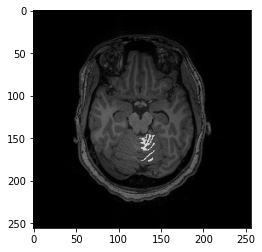

In [15]:
print(Y[0][Y[0].nonzero()])
see_imgs('./dataset_test/train/axial/orig/img/NKI-TRT-20-5_132.png', './dataset_test/train/axial/left-cerebellum-white-matter/img/NKI-TRT-20-5_132.png')

In [16]:
!pip install segmentation-models

     |████████████████████████████████| 50 kB 8.2 MB/s 


In [17]:
import tensorflow as tf
import tensorflow.keras.backend as K
from typing import Callable


def binary_tversky_coef(y_true: tf.Tensor, y_pred: tf.Tensor, beta: float=0.7, smooth: float = 1.) -> tf.Tensor:
    """
    Tversky coefficient is a generalization of the Dice's coefficient. It adds an extra weight (β) to false positives
    and false negatives:
        TC(p, p̂) = p*p̂/[p*p̂ + β*(1-p)*p̂ + (1-β)*p*(1-p̂)]
    When β=1/2, Tversky coefficient is equal to the Dice's coefficient:
        TL(p, p̂) = p*p̂/[p*p̂ + (1/2)*(1-p)*p̂ + (1-(1/2))*p*(1-p̂)]
        = p*p̂/[p*p̂ + (1/2)*p̂ - (1/2)*p*p̂ + (1/2)*p*(1-p̂)]
        = p*p̂/[p*p̂ + (1/2)*p̂ - (1/2)*p*p̂ + (1/2)*p - (1/2)*p*p̂)]
        = p*p̂/[p*p - p*p̂̂ + (1/2)*p̂ + (1/2)*p]
        = p*p̂/[(1/2)*p̂ + (1/2)*p]
        = p*p̂/[(1/2)*(p̂+p)]
        = 2*p*p̂/(p̂+p)
    :param y_true: True masks (tf.Tensor, shape=(<BATCH_SIZE>, <IMAGE_HEIGHT>, <IMAGE_WIDTH>, 1))
    :param y_pred: Predicted masks (tf.Tensor, shape=(<BATCH_SIZE>, <IMAGE_HEIGHT>, <IMAGE_WIDTH>, 1))
    :param beta: Weight coefficient (float)
    :param smooth: Smoothing factor (float, default = 1.)
    :return: Tversky coefficient (tf.Tensor, shape=(<BATCH_SIZE>, <IMAGE_HEIGHT>, <IMAGE_WIDTH>))
    """
    axis_to_reduce = range(1, K.ndim(y_pred))  # All axis but first (batch)
    numerator = K.sum(y_true * y_pred, axis=axis_to_reduce)  # p*p̂
    denominator = y_true * y_pred + beta * (1 - y_true) * y_pred + (1 - beta) * y_true * (1 - y_pred)  # p*p̂ + β*(1-p)*p̂ + (1-β)*p*(1-p̂)
    denominator = K.sum(denominator, axis=axis_to_reduce)

    return (numerator + smooth) / (denominator + smooth)  # (p*p̂ + smooth)/[p*p̂ + β*(1-p)*p̂ + (1-β)*p*(1-p̂) + smooth]


def convert_to_logits(y_pred: tf.Tensor) -> tf.Tensor:
    """
    Converting output of sigmoid to logits.
    :param y_pred: Predictions after sigmoid (<BATCH_SIZE>, shape=(None, <IMAGE_HEIGHT>, <IMAGE_WIDTH>, 1)).
    :return: Logits (tf.Tensor, shape=(<BATCH_SIZE>, <IMAGE_HEIGHT>, <IMAGE_WIDTH>, 1))
    """
    # To avoid unwanted behaviour of log operation
    y_pred = K.clip(y_pred, tf.keras.backend.epsilon(), 1 - tf.keras.backend.epsilon())

    return K.log(y_pred / (1 - y_pred))


def binary_dice_coef_loss(smooth: float = 1.) -> Callable[[tf.Tensor, tf.Tensor], tf.Tensor]:
    """
    Dice coefficient loss:
        DL(p, p̂) = 1 - (2*p*p̂+smooth)/(p+p̂+smooth)
    Used as loss function for binary image segmentation with one-hot encoded masks.
    :param smooth: Smoothing factor (float, default=1.)
    :return: Dice coefficient loss function (Callable[[tf.Tensor, tf.Tensor], tf.Tensor])
    """
    def loss(y_true: tf.Tensor, y_pred: tf.Tensor) -> tf.Tensor:
        """
        Compute the Dice loss (Tversky loss with β=0.5).
        :param y_true: True masks (tf.Tensor, shape=(<BATCH_SIZE>, <IMAGE_HEIGHT>, <IMAGE_WIDTH>, 1))
        :param y_pred: Predicted masks (tf.Tensor, shape=(<BATCH_SIZE>, <IMAGE_HEIGHT>, <IMAGE_WIDTH>, 1))
        :return: Dice coefficient loss for each observation in batch (tf.Tensor, shape=(<BATCH_SIZE>,))
        """
        return 1 - binary_tversky_coef(y_true=y_true, y_pred=y_pred, beta=0.5, smooth=smooth)

    return loss


def binary_weighted_dice_crossentropy_loss(smooth: float = 1.,
                                           beta: float = 0.5) -> Callable[[tf.Tensor, tf.Tensor], tf.Tensor]:
    """
    Weighted Dice cross entropy combination loss is a weighted combination between Dice's coefficient loss and
    binary cross entropy:
        DL(p, p̂) = 1 - (2*p*p̂+smooth)/(p+p̂+smooth)
        CE(p, p̂) = - [p*log(p̂ + 1e-7) + (1-p)*log(1-p̂ + 1e-7)]
        WDCE(p, p̂) = weight*DL + (1-weight)*CE
                   = weight*[1 - (2*p*p̂+smooth)/(p+p̂+smooth)] - (1-weight)*[p*log(p̂ + 1e-7) + (1-p)*log(1-p̂ + 1e-7)]
    Used as loss function for binary image segmentation with one-hot encoded masks.
    :param smooth: Smoothing factor (float, default=1.)
    :param beta: Loss weight coefficient (float, default=0.5)
    :return: Dice cross entropy combination loss (Callable[[tf.Tensor, tf.Tensor], tf.Tensor])
    """
    assert 0. <= beta <= 1., "Loss weight has to be between 0.0 and 1.0"

    def loss(y_true: tf.Tensor, y_pred: tf.Tensor) -> tf.Tensor:
        """
        Compute the Dice cross entropy combination loss.
        :param y_true: True masks (tf.Tensor, shape=(<BATCH_SIZE>, <IMAGE_HEIGHT>, <IMAGE_WIDTH>, 1))
        :param y_pred: Predicted masks (tf.Tensor, shape=(<BATCH_SIZE>, <IMAGE_HEIGHT>, <IMAGE_WIDTH>, 1))
        :return: Dice cross entropy combination loss (tf.Tensor, shape=(<BATCH_SIZE>,))
        """
        cross_entropy = K.binary_crossentropy(target=y_true, output=y_true)

        # Average over each data point/image in batch
        axis_to_reduce = range(1, K.ndim(cross_entropy))
        cross_entropy = K.mean(x=cross_entropy, axis=axis_to_reduce)

        dice_coefficient = binary_tversky_coef(y_true=y_true, y_pred=y_pred, beta=0.5, smooth=smooth)

        return beta*(1. - dice_coefficient) + (1. - beta)*cross_entropy

    return loss

def binary_tversky_loss(beta: float) -> Callable[[tf.Tensor, tf.Tensor], tf.Tensor]:
    """
    Tversky loss:
        TL(p, p̂) = 1 - p*p̂/[p*p̂ + β*(1-p)*p̂ + (1-β)*p*(1-p̂)]
    Used as loss function for binary image segmentation with one-hot encoded masks.
    :param beta: Weight coefficient (float)
    :return: Tversky loss function (Callable[[tf.Tensor, tf.Tensor], tf.Tensor])
    """
    def loss(y_true: tf.Tensor, y_pred: tf.Tensor) -> tf.Tensor:
        """
        Compute the Tversky loss.
        :param y_true: True masks (tf.Tensor, shape=(<BATCH_SIZE>, <IMAGE_HEIGHT>, <IMAGE_WIDTH>, 1))
        :param y_pred: Predicted masks (tf.Tensor, shape=(<BATCH_SIZE>, <IMAGE_HEIGHT>, <IMAGE_WIDTH>, 1))
        :return: Tversky loss (tf.Tensor, shape=(<BATCH_SIZE>,))
        """
        return 1-binary_tversky_coef(y_true, y_pred, beta=beta)

    return loss


def binary_weighted_cross_entropy(beta: float, is_logits: bool = False) -> Callable[[tf.Tensor, tf.Tensor], tf.Tensor]:
    """
    Weighted cross entropy. All positive examples get weighted by the coefficient beta:
        WCE(p, p̂) = −[β*p*log(p̂) + (1−p)*log(1−p̂)]
    To decrease the number of false negatives, set β>1. To decrease the number of false positives, set β<1.
    If last layer of network is a sigmoid function, y_pred needs to be reversed into logits before computing the
    weighted cross entropy. To do this, we're using the same method as implemented in Keras binary_crossentropy:
    https://github.com/tensorflow/tensorflow/blob/r1.10/tensorflow/python/keras/backend.py#L3525
    Used as loss function for binary image segmentation with one-hot encoded masks.
    :param beta: Weight coefficient (float)
    :param is_logits: If y_pred are logits (bool, default=False)
    :return: Weighted cross entropy loss function (Callable[[tf.Tensor, tf.Tensor], tf.Tensor])
    """
    def loss(y_true: tf.Tensor, y_pred: tf.Tensor) -> tf.Tensor:
        """
        Computes the weighted cross entropy.
        :param y_true: True masks (tf.Tensor, shape=(<BATCH_SIZE>, <IMAGE_HEIGHT>, <IMAGE_WIDTH>, 1))
        :param y_pred: Predicted masks (tf.Tensor, shape=(<BATCH_SIZE>, <IMAGE_HEIGHT>, <IMAGE_WIDTH>, 1))
        :return: Weighted cross entropy (tf.Tensor, shape=(<BATCH_SIZE>,))
        """
        if not is_logits:
            y_pred = convert_to_logits(y_pred)

        wce_loss = tf.nn.weighted_cross_entropy_with_logits(labels=y_true, logits=y_pred, pos_weight=beta)

        # Average over each data point/image in batch
        axis_to_reduce = range(1, K.ndim(wce_loss))
        wce_loss = K.mean(wce_loss, axis=axis_to_reduce)

        return wce_loss

    return loss


def binary_balanced_cross_entropy(beta: float, is_logits: bool = False) -> Callable[[tf.Tensor, tf.Tensor], tf.Tensor]:
    """
    Balanced cross entropy. Similar to weighted cross entropy (see weighted_cross_entropy),
    but both positive and negative examples get weighted:
        BCE(p, p̂) = −[β*p*log(p̂) + (1-β)*(1−p)*log(1−p̂)]
    If last layer of network is a sigmoid function, y_pred needs to be reversed into logits before computing the
    balanced cross entropy. To do this, we're using the same method as implemented in Keras binary_crossentropy:
    https://github.com/tensorflow/tensorflow/blob/r1.10/tensorflow/python/keras/backend.py#L3525
    Used as loss function for binary image segmentation with one-hot encoded masks.
    :param beta: Weight coefficient (float)
    :param is_logits: If y_pred are logits (bool, default=False)
    :return: Balanced cross entropy loss function (Callable[[tf.Tensor, tf.Tensor], tf.Tensor])
    """
    if beta == 1.:  # To avoid division by zero
        beta -= tf.keras.backend.epsilon()

    def loss(y_true: tf.Tensor, y_pred: tf.Tensor) -> tf.Tensor:
        """
        Computes the balanced cross entropy in the following way:
            BCE(p, p̂) = −[(β/(1-β))*p*log(p̂) + (1−p)*log(1−p̂)]*(1-β) = −[β*p*log(p̂) + (1-β)*(1−p)*log(1−p̂)]
        :param y_true: Ground truth (tf.Tensor, shape=(<BATCH_SIZE>, <IMAGE_HEIGHT>, <IMAGE_WIDTH>, 1))
        :param y_pred: Predictions (tf.Tensor, shape=(<BATCH_SIZE>, <IMAGE_HEIGHT>, <IMAGE_WIDTH>, 1))
        :return: Balanced cross entropy (tf.Tensor, shape=(<BATCH_SIZE>,))
        """
        if not is_logits:
            y_pred = convert_to_logits(y_pred)

        pos_weight = beta / (1 - beta)
        bce_loss = tf.nn.weighted_cross_entropy_with_logits(labels=y_true, logits=y_pred, pos_weight=pos_weight)
        bce_loss = bce_loss * (1 - beta)

        # Average over each data point/image in batch
        axis_to_reduce = range(1, K.ndim(bce_loss))
        bce_loss = K.mean(bce_loss, axis=axis_to_reduce)

        return bce_loss

    return loss


def binary_focal_loss(beta: float, gamma: float = 2.) -> Callable[[tf.Tensor, tf.Tensor], tf.Tensor]:
    """
    Focal loss is derived from balanced cross entropy, where focal loss adds an extra focus on hard examples in the
    dataset:
        FL(p, p̂) = −[β*(1-p̂)ᵞ*p*log(p̂) + (1-β)*p̂ᵞ*(1−p)*log(1−p̂)]
    When γ = 0, we obtain balanced cross entropy.
    Paper: https://arxiv.org/pdf/1708.02002.pdf
    Used as loss function for binary image segmentation with one-hot encoded masks.
    :param beta: Weight coefficient (float)
    :param gamma: Focusing parameter, γ ≥ 0 (float, default=2.)
    :return: Focal loss (Callable[[tf.Tensor, tf.Tensor], tf.Tensor])
    """
    def loss(y_true: tf.Tensor, y_pred: tf.Tensor) -> tf.Tensor:
        """
        Computes the focal loss.
        :param y_true: True masks (tf.Tensor, shape=(<BATCH_SIZE>, <IMAGE_HEIGHT>, <IMAGE_WIDTH>, 1))
        :param y_pred: Predicted masks (tf.Tensor, shape=(<BATCH_SIZE>, <IMAGE_HEIGHT>, <IMAGE_WIDTH>, 1))
        :return: Focal loss (tf.Tensor, shape=(<BATCH_SIZE>,))
        """
        f_loss = beta * (1 - y_pred) ** gamma * y_true * K.log(y_pred)  # β*(1-p̂)ᵞ*p*log(p̂)
        f_loss += (1 - beta) * y_pred ** gamma * (1 - y_true) * K.log(1 - y_pred)  # (1-β)*p̂ᵞ*(1−p)*log(1−p̂)
        f_loss = -f_loss  # −[β*(1-p̂)ᵞ*p*log(p̂) + (1-β)*p̂ᵞ*(1−p)*log(1−p̂)]

        # Average over each data point/image in batch
        axis_to_reduce = range(1, K.ndim(f_loss))
        f_loss = K.mean(f_loss, axis=axis_to_reduce)

        return f_loss

    return loss

def jaccard_loss(y_true, y_pred, smooth):
    """
    Arguments:
        y_true : Matrix containing one-hot encoded class labels 
                 with the last axis being the number of classes.
        y_pred : Matrix with same dimensions as y_true.
        smooth : smoothing factor for loss function.
    """

    intersection = tf.reduce_sum( y_true * y_pred, axis=-1)
    union = tf.reduce_sum(y_true + y_pred, axis=-1) - intersection
    jac = (intersection + smooth) / (union + smooth)
    
    return (1 - jac) * smooth


def f1_loss(y_true, y_pred, smooth):

    intersection = tf.reduce_sum(y_true * y_pred, axis=-1)
    denominator = tf.reduce_sum(y_true + y_pred, axis=-1)
    f1 = (2 * intersection + smooth) / ( denominator + smooth)
    
    return (1 - f1) * smooth
  
def tversky(y_true, y_pred):
    y_true_pos = K.flatten(y_true)
    y_pred_pos = K.flatten(y_pred)
    true_pos = K.sum(y_true_pos * y_pred_pos)
    false_neg = K.sum(y_true_pos * (1-y_pred_pos))
    false_pos = K.sum((1-y_true_pos)*y_pred_pos)
    alpha = 0.7
    return (true_pos + smooth)/(true_pos + alpha*false_neg + (1-alpha)*false_pos + smooth)

def tversky_loss(y_true, y_pred):
    return 1 - tversky(y_true,y_pred)

def focal_tversky(y_true,y_pred):
    pt_1 = tversky(y_true, y_pred)
    gamma = 0.75
    return K.pow((1-pt_1), gamma)

def binary_focal_tversky_loss(y_true, y_pred, beta=0.7):
  pt_1 = binary_tversky_coef(y_true, y_pred, beta=beta)
  gamma = 0.75
  return K.pow((1-pt_1), gamma)

In [18]:
from tensorflow.keras import backend as K
import segmentation_models as sm

smooth = 1.
def dice_coef(y_true, y_pred):
    y_true_f = K.flatten(y_true)
    y_pred_f = K.flatten(y_pred)
    intersection = K.sum(y_true_f * y_pred_f)
    return (2. * intersection + smooth) / (K.sum(y_true_f) + K.sum(y_pred_f) + smooth)

def dice_coef_loss(y_true, y_pred):
  return -dice_coef(y_true, y_pred)

def focal_loss(gamma=2, alpha=0.75):
  def focal_loss_fixed(y_true, y_pred):#with tensorflow
    eps = 1e-12
    y_pred=K.clip(y_pred,eps,1.-eps)#improve the stability of the focal loss and see issues 1 for more information
    pt_1 = tf.where(tf.equal(y_true, 1), y_pred, tf.ones_like(y_pred))
    pt_0 = tf.where(tf.equal(y_true, 0), y_pred, tf.zeros_like(y_pred))
    return -K.sum(alpha * K.pow(1. - pt_1, gamma) * K.log(pt_1))-K.sum((1-alpha) * K.pow( pt_0, gamma) * K.log(1. - pt_0))
  
  return focal_loss_fixed

Segmentation Models: using `keras` framework.


In [19]:
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
from tensorflow.keras import backend as K
# Callbacks
	
monitor = 'val_loss'
mode = 'min'

# Early stopping
early_stop = EarlyStopping(
    monitor=monitor, 
    mode=mode, 
    verbose=1,
    patience=25
)

# Model Checkpoing
model_check = ModelCheckpoint(
    'best_model.hdf5', 
    save_best_only=True,
    save_weights_only=True, 
    monitor=monitor, 
    mode=mode
)

smooth = 100

def iou(y_true, y_pred):
    intersection = K.sum(y_true * y_pred)
    sum_ = K.sum(y_true + y_pred)
    jac = (intersection + smooth) / (sum_ - intersection + smooth)
    return jac

In [29]:
# lr_schedule = tf.keras.optimizers.schedules.ExponentialDecay(
#     initial_learning_rate=1e-4,
#     decay_steps=40,
#     decay_rate=0.9)

config_ml.learning_rate = 1e-6
# opt = tf.keras.optimizers.SGD(lr=config_ml.learning_rate, momentum=config_ml.momentum, nesterov=True, clipvalue=1.)
opt = tf.keras.optimizers.Adam(learning_rate=config_ml.learning_rate)

# loss = sm.losses.DiceLoss() + (1 * sm.losses.BinaryFocalLoss())
# loss = sm.losses.BinaryFocalLoss()
# loss = sm.losses.DiceLoss()
# loss = tf.keras.losses.BinaryCrossentropy(from_logits=True)
# loss = 'binary_crossentropy'
loss = binary_tversky_loss(beta=0.7)

model.compile(
    optimizer=opt,
    loss=loss,#loss='binary_crossentropy',#tf.keras.losses.BinaryCrossentropy(from_logits=True),
    metrics=[
        sm.metrics.iou_score, 
        sm.metrics.FScore(threshold=0.5),
        dice_coef
        # binary_tversky_coef,
        # tf.keras.metrics.BinaryAccuracy(name="accuracy"),
    ] 
)

(<segmentation_models.metrics.FScore at 0x7fa78b782f10>,)

In [21]:
tf.keras.backend.clear_session()

# epochs_train = 3725 // config_ml.batch_size
# epochs_test = (950) // config_ml.batch_size

config_ml.num_epochs = 80 

# model_history = model.fit(train_gen, 
#                           epochs=config_ml.num_epochs,
#                           steps_per_epoch=epochs_train,
#                           validation_steps=epochs_test,
#                           validation_data=val_gen,
#                           # callbacks=[early_stop, model_check]
# )

model_history = model.fit(x=x_train,
                          y=y_train,
                          batch_size=config_ml.batch_size, 
                          epochs=config_ml.num_epochs,
                          # steps_per_epoch=epochs_train,
                          # validation_steps=epochs_test,
                          validation_data=(x_val, y_val),
                          # callbacks=[early_stop, model_check]
)

Epoch 1/80
88/88 [==============================] - 135s 1s/step - loss: 0.6717 - iou_score: 0.0314 - f1-score: 0.0402 - dice_coef: 0.0608 - val_loss: 0.8961 - val_iou_score: 0.0218 - val_f1-score: 0.0366 - val_dice_coef: 0.0426
Epoch 2/80
88/88 [==============================] - 92s 1s/step - loss: 0.4874 - iou_score: 0.0456 - f1-score: 0.0426 - dice_coef: 0.0872 - val_loss: 0.8737 - val_iou_score: 0.0441 - val_f1-score: 0.0563 - val_dice_coef: 0.0842
Epoch 3/80
88/88 [==============================] - 91s 1s/step - loss: 0.4082 - iou_score: 0.0577 - f1-score: 0.0464 - dice_coef: 0.1089 - val_loss: 0.7868 - val_iou_score: 0.0366 - val_f1-score: 0.0318 - val_dice_coef: 0.0705
Epoch 4/80
88/88 [==============================] - 92s 1s/step - loss: 0.3528 - iou_score: 0.0710 - f1-score: 0.0510 - dice_coef: 0.1321 - val_loss: 0.4641 - val_iou_score: 0.0772 - val_f1-score: 0.0573 - val_dice_coef: 0.1406
Epoch 5/80
88/88 [==============================] - 92s 1s/step - loss: 0.3333 - iou_sc

In [22]:
import matplotlib.pyplot as plt
%matplotlib inline

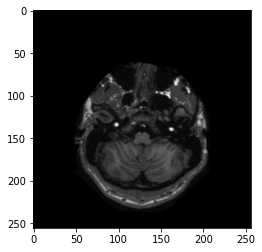

In [23]:
name = 'OASIS-TRT-20-6_171' # 'OASIS-TRT-20-6_171' # Twins-2-1_150 NKI-TRT-20-5_132
test_img = cv2.imread(f"./dataset_test/train/axial/orig/img/{name}.png", cv2.IMREAD_GRAYSCALE)
# test_img = cv2.resize(test_img, (SIZE_Y, SIZE_X))
plt.imshow(test_img, cmap='gray')
test_img = np.expand_dims(test_img, axis=0)

prediction = model.predict(test_img/255.0)

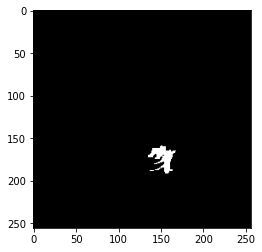

In [24]:
seg_img = cv2.imread(f"./dataset_test/train/axial/left-cerebellum-white-matter/img/{name}.png", cv2.IMREAD_GRAYSCALE)            
# test_img = cv2.resize(test_img, (SIZE_Y, SIZE_X))
plt.imshow(seg_img, cmap='gray')

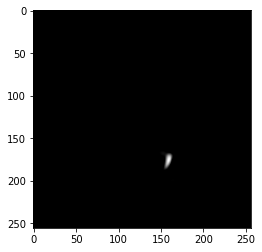

In [25]:
prediction_image = prediction.reshape((256, 256))*255.0
plt.imshow(prediction_image, cmap='gray')

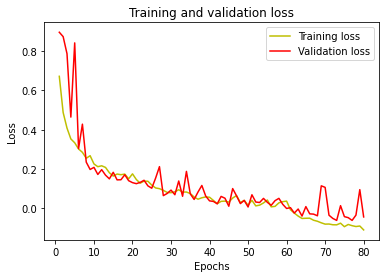

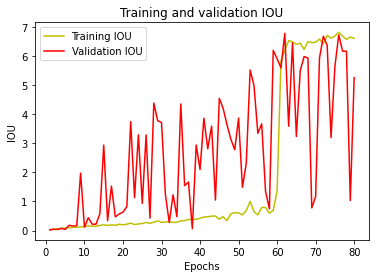

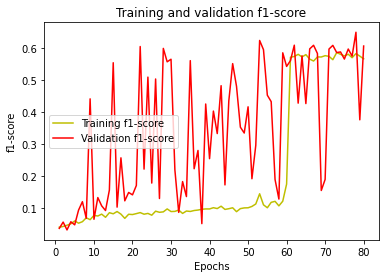

In [27]:
loss = model_history.history['loss']
val_loss = model_history.history['val_loss']
epochs = range(1, len(loss) + 1)
plt.plot(epochs, loss, 'y', label='Training loss')
plt.plot(epochs, val_loss, 'r', label='Validation loss')
plt.title('Training and validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

acc = model_history.history['iou_score']
val_acc = model_history.history['val_iou_score']

plt.plot(epochs, acc, 'y', label='Training IOU')
plt.plot(epochs, val_acc, 'r', label='Validation IOU')
plt.title('Training and validation IOU')
plt.xlabel('Epochs')
plt.ylabel('IOU')
plt.legend()
plt.show()

f1score = model_history.history['f1-score']
val_f1score = model_history.history['val_f1-score']

plt.plot(epochs, f1score, 'y', label='Training f1-score')
plt.plot(epochs, val_f1score, 'r', label='Validation f1-score')
plt.title('Training and validation f1-score')
plt.xlabel('Epochs')
plt.ylabel('f1-score')
plt.legend()
plt.show()

In [ ]:
def display(display_list):
  plt.figure(figsize=(15, 15))

  title = ['Input Slice', 'True Mask', 'Predicted Mask']

  for i in range(len(display_list)):
    plt.subplot(1, len(display_list), i+1)
    plt.title(title[i])
    arr = np.reshape(display_list[i], (256, 256))
    res = arr.nonzero()
    print(arr[res], " ", arr.shape)
    plt.imshow(tf.keras.preprocessing.image.array_to_img(display_list[i]), cmap='bone')
    plt.axis('off')
  plt.show()

In [ ]:
image, mask = next(train_gen)

In [ ]:
image[0][image[0].nonzero()]

array([0.00392157, 0.00392157, 0.00784314, ..., 0.00392157, 0.00392157,
       0.00392157], dtype=float32)

In [ ]:
mask[0][mask[0].nonzero()]

array([1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       1., 1., 1., 1., 1.

[0.00392157 0.00392157 0.00784314 ... 0.00392157 0.00392157 0.00392157]   (256, 256)
[1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.
 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.
 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.
 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.
 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.
 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.
 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.
 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.
 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.
 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.
 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.
 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.
 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.

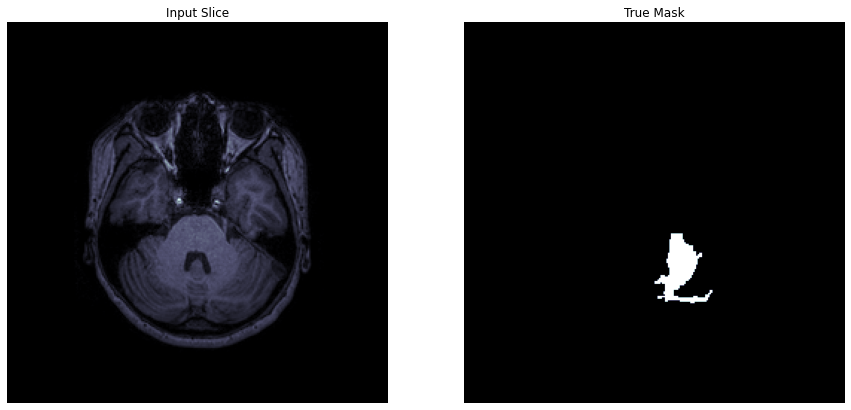

In [ ]:
display([image[0], mask[0]])

In [ ]:
import os
from PIL import Image, ImageOps

def check_mask_img(path):
  if os.path.exists(path):
    img = ImageOps.grayscale(Image.open(path))
    arr = np.asarray(img)
    res = arr.nonzero()

    if (res[0].shape[0] or res[1].shape[0]):
      print(arr[res])
      plt.imshow(img)
      plt.show()
      return True

  return False

[255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255
 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255
 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255
 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255
 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255
 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255
 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255
 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255
 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255
 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255
 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255
 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255
 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255
 255 255 255 255 255 255 255 255 255 255 255 255 25

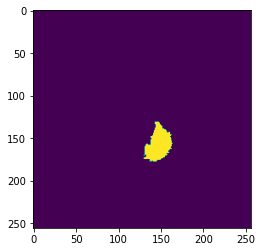

True

In [ ]:
check_mask_img("dataset_test/train/axial/left-cerebellum-white-matter/img/HLN-12-4_156.png")

In [ ]:
def create_mask(pred_mask):
  pred_mask = tf.argmax(pred_mask, axis=-1)
  pred_mask = pred_mask[..., tf.newaxis]
  return pred_mask[0]

def show_predictions(model, dataset=None, num=1):
  if dataset:
    for n in range(num):
      image, mask = next(dataset)
      pred_mask = model.predict(image)
      display([image[0], mask[0], create_mask(pred_mask)])
  else:
    pass
    # display([sample_image, sample_mask,
    #          create_mask(model.predict(sample_image[tf.newaxis, ...]))])

In [ ]:
show_predictions(model, train_gen, 20)

NameError: ignored

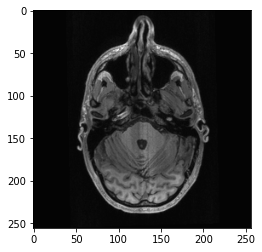

In [ ]:
test_img = cv2.imread('./dataset_test/train/axial/orig/img/Twins-2-1_156.png', cv2.IMREAD_GRAYSCALE)
# test_img = cv2.resize(test_img, (SIZE_Y, SIZE_X))
plt.imshow(test_img, cmap='gray')
test_img = np.expand_dims(test_img, axis=0)

prediction = model.predict(test_img/255.0)

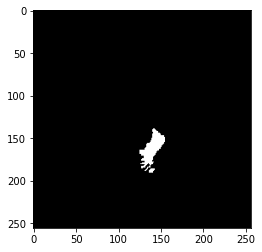

In [ ]:
seg_img = cv2.imread('./dataset_test/train/axial/left-cerebellum-white-matter/img/Twins-2-1_156.png', cv2.IMREAD_GRAYSCALE)       
# test_img = cv2.resize(test_img, (SIZE_Y, SIZE_X))
plt.imshow(seg_img, cmap='gray')

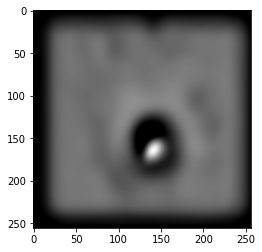

In [ ]:
prediction_image = prediction.reshape((256, 256))*255.0
plt.imshow(prediction_image, cmap='gray')